In [131]:
import os
import requests
import random
import time
import pandas as pd
import numpy as np
import jieba
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from lxml import etree

In [196]:
class Crawl_Liepin():

    user_agent = [
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36 OPR/26.0.1656.60',
        'Mozilla/5.0 (Windows NT 5.1; U; en; rv:1.8.1) Gecko/20061208 Firefox/2.0.0 Opera 9.50',
        'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; en) Opera 9.50',
        'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:34.0) Gecko/20100101 Firefox/34.0',
        'Mozilla/5.0 (X11; U; Linux x86_64; zh-CN; rv:1.9.2.10) Gecko/20100922 Ubuntu/10.10 (maverick) Firefox/3.6.10',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534.57.2 (KHTML, like Gecko) Version/5.1.7 Safari/534.57.2',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.71 Safari/537.36',
        'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
        'Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US) AppleWebKit/534.16 (KHTML, like Gecko) Chrome/10.0.648.133 Safari/534.16',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.101 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.1 (KHTML, like Gecko) Chrome/21.0.1180.71 Safari/537.1 LBBROWSER',
        'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; .NET4.0C; .NET4.0E; LBBROWSER)',
        'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; .NET4.0C; .NET4.0E; QQBrowser/7.0.3698.400)',
        'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; QQDownload 732; .NET4.0C; .NET4.0E)',
        'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.84 Safari/535.11 SE 2.X MetaSr 1.0',
        'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Trident/4.0; SV1; QQDownload 732; .NET4.0C; .NET4.0E; SE 2.X MetaSr 1.0)',
    ]
    job_urls_to_crawl = {}
    job_urls_crawled = {}
    
    def get_id(self, url, url_type='job'):
        return url.split('/')[-1][:-6]
    
    def store_url(self, url, url_type='job'):
        job_id = self.get_id(url)
        if job_id not in self.job_urls_to_crawl and job_id not in self.job_urls_crawled:
            self.job_urls_to_crawl[job_id] = url
            
    def transfer_url(self, id_, url_type='job'):
        self.job_urls_crawled[id_] = self.job_urls_to_crawl[id_]
        self.job_urls_to_crawl.pop(id_)
    
    def get_main_url(self, page, city='sz'):
        url = 'https://www.liepin.com/city-%s/zhaopin/'%city
        if page >= 1:
            url += 'pn%s/'%(page-1)
        #url += '?key=&d_sfrom=search_city&d_ckId=c72351a8c506da0d2bf13032a46d9b98&d_curPage=1&d_pageSize=40&d_headId=c72351a8c506da0d2bf13032a46d9b98'
        return url

    # Crawl the page
    def crawl(self, url, sleep=0.1):
        headers = {'user-agent': random.choice(self.user_agent)}
        response = requests.get(url=url, headers=headers)
        time.sleep(sleep)
        return response.text

    def get_job_url(self, text):
        f = etree.HTML(text)
        urls = [i for i in f.xpath('//@href') if '/job/' in i and 'shtml' in i]
        for ii in urls:
            self.store_url(ii)
    
    def parse_job(self, text, urls_discover=False):
        dic = {}
        f = etree.HTML(text)
        job_url = self.retrieve(f.xpath('//link[@rel="canonical"]/@href'))
        dic['job_id'] = self.get_id(job_url)
        dic['job_title'] = self.retrieve(f.xpath('//h1/text()'))
        dic['job_url'] = job_url
        dic['company']= self.retrieve(f.xpath('//h3/a/@title'))
        dic['company_url']= self.retrieve(f.xpath('//h3/a/@href'))
        dic['salary']= self.retrieve(f.xpath("//p[@class='job-item-title']/text()")).strip()
        dic['location'] = self.retrieve(f.xpath("//p[@class='basic-infor']/span/a/text()"))
        if self.retrieve(f.xpath("//em[@class='job-title-icon-inclined']")) is not None:
            dic['eager'] = '急聘'
        dic['list_date'] = self.retrieve(f.xpath("//time[@title]/@title"))
        job_quali = f.xpath("//div[@class='job-qualifications']/span/text()")
        dic['degree'] = job_quali[0]
        dic['experience'] = job_quali[1]
        dic['language'] = job_quali[2]
        dic['age'] = job_quali[3]
        dic['tag'] = f.xpath("//ul[@class='comp-tag-list clearfix']/li/span/text()")
        dic['job_desc'] = [ii.strip() for ii in f.xpath("//div[@class='content content-word']/text()") if len(ii.strip())>0]
        dic['company_desc'] = [ii.strip() for ii in f.xpath("//div[@class='info-word']/text()") if len(ii.strip())>0]
        info_labels = f.xpath("//div[@class='content']/ul/li/span/text()")
        info_texts = f.xpath("//div[@class='content']/ul/li/label/text()")
        if len(info_labels) == len(info_texts):
            if "下属人数：" in info_labels:
                dic['num_of_subs'] = info_texts[info_labels.index("下属人数：")]
            if "所属部门：" in info_labels:
                dic['department'] = info_texts[info_labels.index("所属部门：")]
            if "汇报对象：" in info_labels:
                dic['supervisor'] = info_texts[info_labels.index("汇报对象：")]
            if "企业性质：" in info_labels:
                dic['type_of_company'] = info_texts[info_labels.index("企业性质：")]
            if "企业规模：" in info_labels:
                dic['scale_of_company'] = info_texts[info_labels.index("企业规模：")]
                
        if urls_discover == True:
            urls = [i for i in f.xpath('//@href') if '/job/' in i and 'shtml' in i]
            for ii in urls:
                self.store_url(ii)
        
        return dic
    
    # Compatible with the xpath lib, return the first value if finded or None if not
    def retrieve(self, lis):
        if len(lis) > 0:
            return lis[0]
        else:
            return None
        
    def run(self, page, max_crawl=10000):
        result = []
        for i in tqdm(range(1, page+1)):
            try:
                main_url = crawler.get_main_url(i)
                text = crawler.crawl(main_url)
                crawler.get_job_url(text)
            except: pass
        for _ in tqdm(range(max_crawl)):
            if len(self.job_urls_to_crawl) > 0:
                job_id = random.choice(list(crawler.job_urls_to_crawl.keys()))
                try:
                    text = crawler.crawl(self.job_urls_to_crawl[job_id])
                    result.append(crawler.parse_job(text, urls_discover=True))
                except: pass
                self.transfer_url(job_id)
            else: break
            if _ % 500 == 0:
                pd.DataFrame(result).to_csv('temp.csv')
        return pd.DataFrame(result)
    
def count_words(word, text):
    n = len(word)
    count = 0
    for i in range(len(text)-n):
        if text[i: i+n] == word:
            count += 1
    return count

def clean(df):
    df = df.copy()
    missing_num = -1
    top_n_tags = 30
    top_n_departments = 20
    skills = ['PYTHON', 'JAVA', 'EXCEL', 'CFA', 'CPA', 'PPT', '证券从业资格证', '法律职业资格证', '会计', '建造师', 'SQL',
               '机器学习', '神经网络', 'C++', 'JAVASCRIPT', 'VUE', 'REACT', 'ANGULAR', 'TENSORFLOW', 'PYTORCH',
               'MBA', 'FRM', 'ACCA', 'CFP', 'GO', '区块链', 'SCALA', 'SWIFT', 'IOS', 'ANDROID', 'PHP', 'R', 'MATLAB', 'C', 
               'CSS', '数据分析', '数据挖掘', '算法', 'IOT', '.NET', 'ORACLE', 'UNITY', 'PHOTOSHOP']
    degree_dict = {
                '高中及以上': '高中',
                '中专/中技及以上': '高中',
                '学历不限': '学历不限',
                '大专及以上': '大专',
                '本科及以上': '本科',
                '统招本科': '本科',
                '硕士及以上': '硕士',
                '博士': '博士',
                '博士后': '博士',}
    
    df = df.fillna('')
    df['city'] = df['location'].apply(lambda x: x.split('-')[0] if '-' in x else x)
    df['location'] = df['location'].apply(lambda x: x.split('-')[1] if '-' in x else None)
    df['salary_low'] = df['salary'].apply(lambda x: x.split('-')[0] if '-' in x else missing_num).astype(int)
    df['salary_high'] = df['salary'].apply(lambda x: x.split('-')[1][:-1] if '-' in x else missing_num).astype(int)
    df['salary'] = (df['salary_low'] + df['salary_high']) / 2
    df['age_low'] = df['age'].apply(lambda x: x.split('-')[0] if '-' in x else missing_num).astype(int)
    df['age_high'] = df['age'].apply(lambda x: x.split('-')[1][:-1] if '-' in x else missing_num).astype(int)
    df['experience'] = df['experience'].apply(lambda x: x[:x.index('年')] if '年' in x else missing_num).astype(int)
    df['num_of_subs'] = df['num_of_subs'].apply(lambda x: str(x)[:-1] if '人' in str(x) else missing_num).astype(int)
    df['english'] = df['language'].apply(lambda x: 1 if '英语' in x else 0)
    top_departments = df['department'].value_counts()[:20].index
    df['department'] = df['department'].apply(lambda x: x if x in top_departments and len(x)>0 else '其它')
    df['degree'] = df['degree'].apply(lambda x: degree_dict[x])
    
    
    cols = ['job_id', 'job_title', 'salary', 'salary_high', 'salary_low','age_high', 'age_low', 'degree', 'company', 'department',
       'experience', 'english', 'list_date', 'city', 'location', 'num_of_subs']
    
    for (ii, jj) in Counter(np.sum(df['tag'])).most_common(top_n_tags):
        df['tag_%s'%ii] = df['tag'].apply(lambda x: 1 if ii in x else 0)
        cols.append('tag_%s'%ii)
        
    for ii in skills:
        df['skill_%s'%ii] = df['job_desc'].apply(lambda x: 1 if ii in ''.join(x).upper() else 0)
        cols.append('skill_%s'%ii)
    
    return df[cols]

In [3]:
crawler = Crawl_Liepin()
df = crawler.run(100, max_crawl=20000)

In [3]:
def up(path, n=1):
    for i in range(n):
        path = os.path.dirname(path)
    return path

path = os.path.join(up(os.getcwd(), 2), 'datasets')
df = pd.read_csv(os.path.join(path, 'crawled_liepin_01.csv')).drop('Unnamed: 0', axis=1)
df['job_desc'] = df['job_desc'].apply(eval)
df['tag'] = df['tag'].apply(eval)

In [197]:
dff = clean(df)
dff = dff[dff['city']=='深圳'].reset_index(drop=True)

In [158]:
skill_salary = {}
tag_salary = {}
length = len(dff)
for i in dff.columns:
    if i[:5] == 'skill':
        skill_salary[i[6:]] = (np.round(dff.loc[dff[i]==1, 'salary_high'].mean(), 2), np.round(dff[i].value_counts()[1] / len(dff), 4))
    elif i[:3] == 'tag':
        tag_salary[i[4:]] = (np.round(dff.loc[dff[i]==1, 'salary_high'].mean(), 2), np.round(dff[i].value_counts()[1] / len(dff), 4))
    else: pass

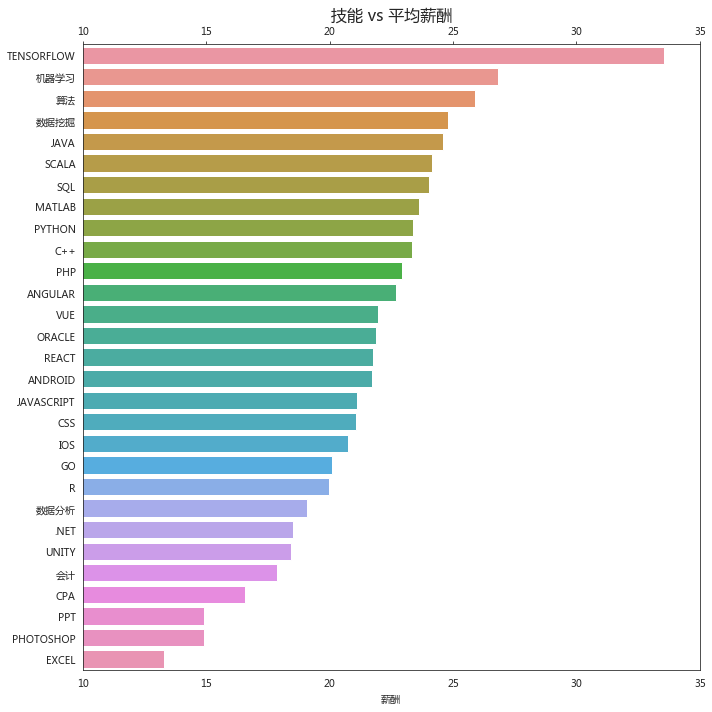

In [313]:
# Looking at salary vs skills
dfp = pd.DataFrame(skill_salary).T.rename({0: '薪酬', 1: '占比'}, axis=1).sort_values('薪酬', ascending=False)
dfp = dfp[(dfp['占比']<0.3) & (dfp['占比']>0.003)]

sns.set_style('white', {'font.sans-serif': ['Microsoft YaHei', 'Arial']})
plt.rcParams['axes.titlesize'] = 16

plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

f = plt.figure(figsize=(10, 10))
sns.barplot(x='薪酬', y=dfp.index, data=dfp, orient='h', ci=False)
plt.title('技能 vs 平均薪酬')
plt.xlim(10, 35)
f.tight_layout()
f.savefig('skill_salary.png', dpi=150)

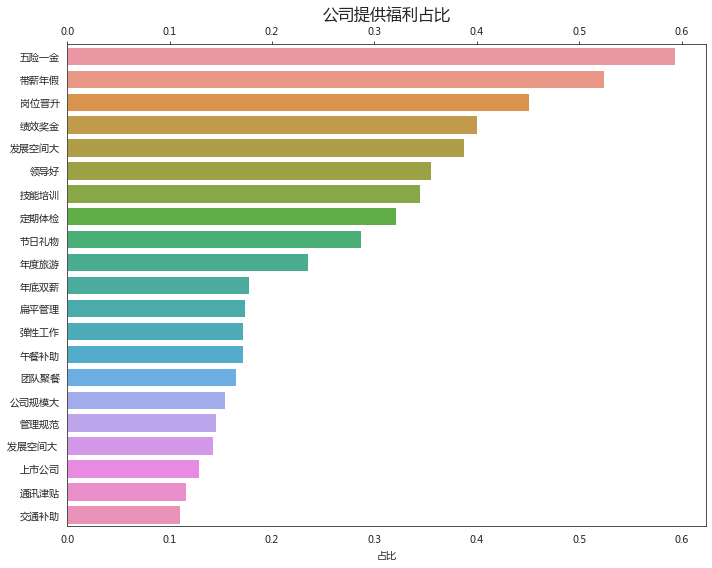

In [316]:
# Look at the percentage of tags

dfp = pd.DataFrame(tag_salary).T.rename({0: '薪酬', 1: '占比'}, axis=1).sort_values('占比', ascending=False)
dfp = dfp[dfp['占比']>0.1]

plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.rcParams['axes.titlesize'] = 16

f = plt.figure(figsize=(10, 8))
plt.title('公司提供福利占比')
sns.barplot(x='占比', y=dfp.index, data=dfp, orient='h', ci=False)
f.tight_layout()
f.savefig('tag_salary.png', dpi=150)

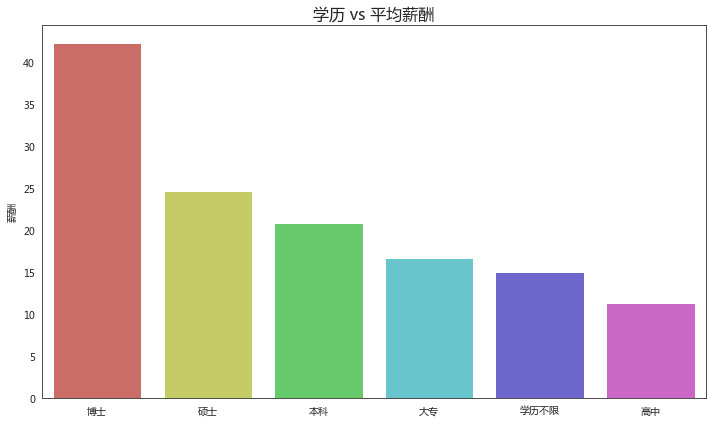

In [318]:
dfp = dff.groupby('degree')['salary_high'].mean().sort_values(ascending=False)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
f = plt.figure(figsize=(10, 6))
plt.title('学历 vs 平均薪酬')
sns.barplot(x=dfp.index, y=dfp, orient='v', ci=False, palette='hls')
plt.xlabel('')
plt.ylabel('薪酬')
f.tight_layout()
f.savefig('degree_salary.png', dpi=150)

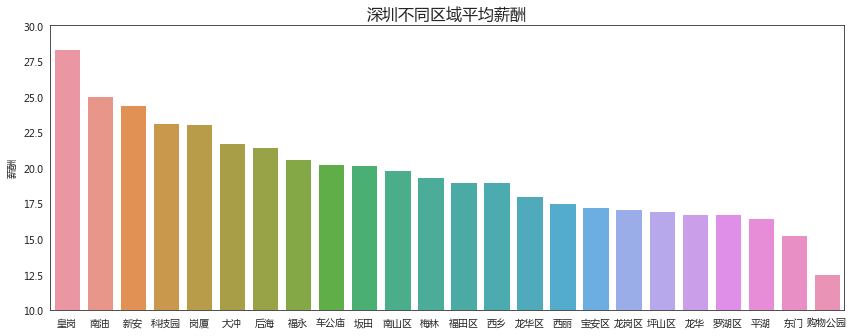

In [325]:
# Salary by location
loc_sorted = dff.groupby('location')['salary_high'].count().sort_values(ascending=False)
loc_sorted = loc_sorted[loc_sorted>30]
dfp = dff[dff['location'].apply(lambda x: x in loc_sorted.index)].groupby('location')['salary_high'].mean().sort_values(ascending=False)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
f = plt.figure(figsize=(12, 5))
sns.barplot(x=dfp.index, y=dfp, orient='v', ci=False)
plt.ylim(10, 30)
plt.title('深圳不同区域平均薪酬')
f.tight_layout()
plt.xlabel('')
plt.ylabel('薪酬')
f.savefig('location_salary.png', dpi=150)

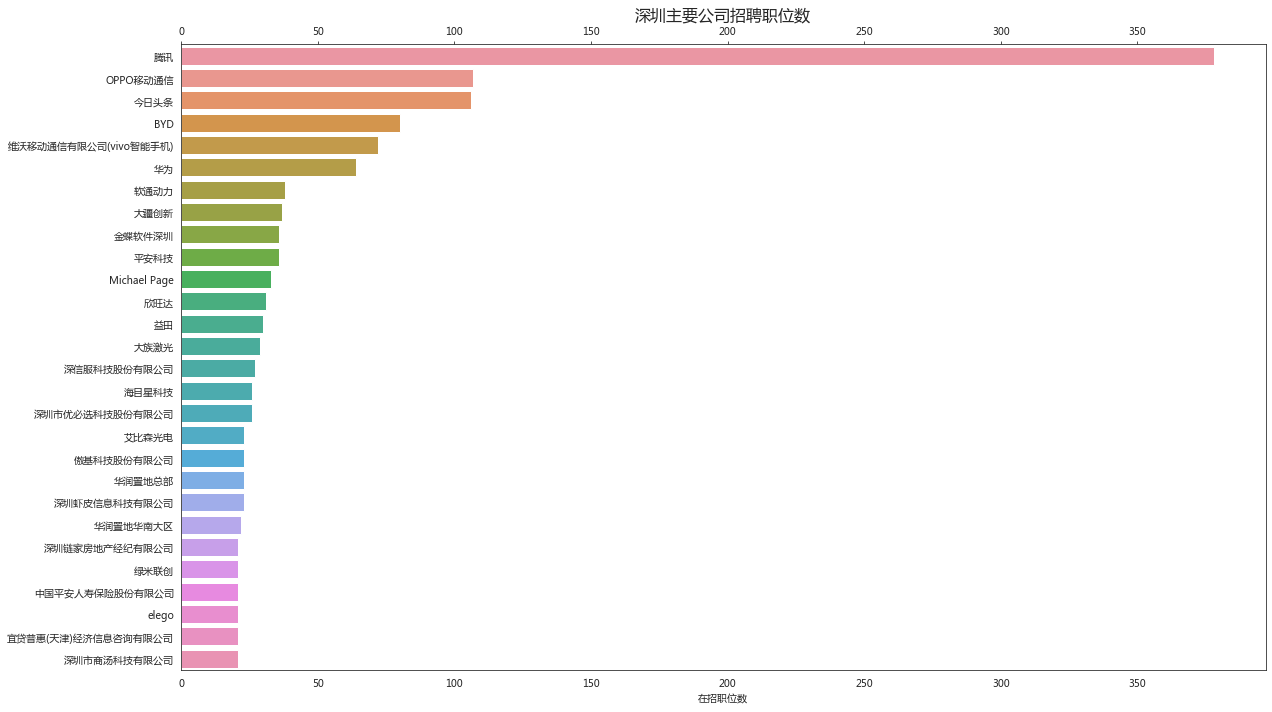

In [326]:
# Salary by location
com_sorted = dff.groupby('company')['salary_high'].count().sort_values(ascending=False)
com_sorted = com_sorted[com_sorted>20]
dfp = dff[dff['company'].apply(lambda x: x in com_sorted.index)].groupby('company')['job_title'].count().sort_values(ascending=False)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
f = plt.figure(figsize=(18, 10))
sns.barplot(x=dfp, y=dfp.index, orient='h', ci=False)
plt.title('深圳主要公司招聘职位数')
f.tight_layout()
plt.xlabel('在招职位数')
plt.ylabel('')
f.savefig('com_count.png', dpi=150)

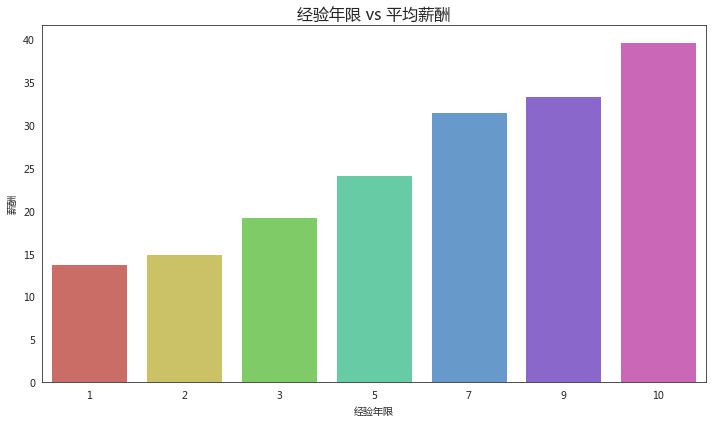

In [324]:
# Experien vs salary
dfp = dff[['salary_high', 'experience']]
dfp = dfp[dfp['experience'] > -1]
dfp.loc[dfp['experience']>10, 'experience'] = 10
dfp.loc[dfp['experience']==4, 'experience'] = 3
dfp.loc[(dfp['experience']>5) & (dfp['experience']<7), 'experience'] = 7
dfp.loc[(dfp['experience']>7) & (dfp['experience']<10), 'experience'] = 9
dfp = dfp.groupby('experience')['salary_high'].mean()
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
f = plt.figure(figsize=(10, 6))
sns.barplot(x=dfp.index, y=dfp, orient='v', ci=False, palette='hls')
plt.title('经验年限 vs 平均薪酬')
f.tight_layout()
plt.xlabel('经验年限')
plt.ylabel('薪酬')
f.savefig('experience_salary.png', dpi=150)

In [297]:
dfp.groupby('experience')['salary_high'].mean()

experience
1     13.768838
2     14.955776
3     19.195536
5     24.089552
7     31.476510
9     33.290030
10    39.595918
Name: salary_high, dtype: float64

In [14]:
c = Counter(jieba.cut(text.upper()))

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/9s/txtf73691dl82hxmz3x431hm0000gp/T/jieba.cache
Loading model cost 2.339 seconds.
Prefix dict has been built succesfully.


In [45]:
skills = ['PYTHON', 'JAVA', 'EXCEL', 'CFA', 'CPA', 'PPT', '证券从业资格证', '法律职业资格证', '会计', '建造师', 'SQL',
           '机器学习', '神经网络', 'C++', 'JAVASCRIPT', 'VUE', 'REACT', 'ANGULAR', 'TENSORFLOW', 'PYTORCH',
           'MBA', 'FRM', 'ACCA', 'CFP', 'GO', '区块链', 'SCALA', 'SWIFT', 'IOS', 'ANDROID', 'PHP', 'R', 'MATLAB', 'C', 
           'CSS', '数据分析', '数据挖掘', '算法', 'IOT', '.NET', 'ORACLE', 'UNITY', 'PHOTOSHOP']

for i in skills:
    jieba.add_word(i)
c = Counter(jieba.cut(text.upper()))
for i in skills:
    print(i, c[i])

PYTHON 918
JAVA 1220
EXCEL 1262
CFA 47
CPA 108
PPT 699
证券从业资格证 9
法律职业资格证 17
会计 535
建造师 65
SQL 1506
机器学习 486
神经网络 57
C++ 1134
JAVASCRIPT 347
VUE 205
REACT 186
ANGULAR 98
TENSORFLOW 133
PYTORCH 47
MBA 72
FRM 21
ACCA 32
CFP 27
GO 1652
区块链 87
SCALA 98
SWIFT 36
IOS 428
ANDROID 880
PHP 182
R 189
MATLAB 166
C 1194
OBJECTIVE-C 0
数据分析 2299
数据挖掘 298
算法 1963


In [328]:
count_words('RNN', text.upper())

26